In [2]:
from tensorflow.keras.layers import Conv2D, Input, MaxPool2D, Reshape, Activation, Flatten, Dense, Permute, PReLU
from tensorflow.keras.models import Model, Sequential
import tensorflow as tf
import numpy as np
import utils
import cv2

#-----------------------------#
#   Get the face frame roughly
#   Output bbox location and whether there is a face
#-----------------------------#
def create_Pnet(weight_path):
    input = Input(shape=[None, None, 3])

    x = Conv2D(10, (3, 3), strides=1, padding='valid', name='conv1')(input)
    x = PReLU(shared_axes=[1,2],name='PReLU1')(x)
    x = MaxPool2D(pool_size=2)(x)
    
    x = Conv2D(16, (3, 3), strides=1, padding='valid', name='conv2')(x)
    x = PReLU(shared_axes=[1,2],name='PReLU2')(x)
    
    x = Conv2D(32, (3, 3), strides=1, padding='valid', name='conv3')(x)
    x = PReLU(shared_axes=[1,2],name='PReLU3')(x)
    
    classifier = Conv2D(2, (1, 1), activation='softmax', name='conv4-1')(x)
    
    bbox_regress = Conv2D(4, (1, 1), name='conv4-2')(x)

    model = Model([input], [classifier, bbox_regress])
    model.load_weights(weight_path, by_name=True)
    
    return model

#-----------------------------#
#   The third paragraph of mtcnn
#   Refine the frame and get five points
#-----------------------------#
def create_Onet(weight_path):
    input = Input(shape = [48,48,3])
    
    x = Conv2D(32, (3, 3), strides=1, padding='valid', name='conv1')(input)
    x = PReLU(shared_axes=[1,2],name='prelu1')(x)
    x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    
    x = Conv2D(64, (3, 3), strides=1, padding='valid', name='conv2')(x)
    x = PReLU(shared_axes=[1,2],name='prelu2')(x)
    x = MaxPool2D(pool_size=3, strides=2)(x)
     
    x = Conv2D(64, (3, 3), strides=1, padding='valid', name='conv3')(x)
    x = PReLU(shared_axes=[1,2],name='prelu3')(x)
    x = MaxPool2D(pool_size=2)(x)
    
    x = Conv2D(128, (2, 2), strides=1, padding='valid', name='conv4')(x)
    x = PReLU(shared_axes=[1,2],name='prelu4')(x)
    
    x = Permute((3,2,1))(x)

    
    x = Flatten()(x)
    
    x = Dense(256, name='conv5') (x)
    x = PReLU(name='prelu5')(x)

    
    classifier = Dense(2, activation='softmax',name='conv6-1')(x)
    
    bbox_regress = Dense(4,name='conv6-2')(x)
    
    landmark_regress = Dense(10,name='conv6-3')(x)

    model = Model([input], [classifier, bbox_regress, landmark_regress])
    model.load_weights(weight_path, by_name=True)

    return model

In [3]:
Pnet = create_Pnet('pnet.h5')

Onet = create_Onet('onet.h5')
Onet.save('my_onet.h5')

In [4]:
# from utils import calculateScales
def detectFace( img, threshold): 
  #-----------------------------#
  #  Normalized
  #-----------------------------#
  copy_img = (img.copy() - 127.5) / 127.5
  origin_h, origin_w, _ = copy_img.shape
    #-----------------------------#
    #   Calculate the original input image
    #   The ratio of each zoom
    #-----------------------------#
  scales = utils.calculateScales(img)
  out = []
    #-----------------------------#
    #   Roughly calculate the face frame
    #   pnet part
    #-----------------------------#
  for scale in scales:
    hs = int(origin_h * scale)
    ws = int(origin_w * scale)
    scale_img = cv2.resize(copy_img, (ws, hs))
    inputs = scale_img.reshape(1, *scale_img.shape)
    #ouput = self.Pnet.predict(inputs)
    ouput = Pnet.predict(inputs)
    out.append(ouput)

  image_num = len(scales)
  rectangles = []
  for i in range(image_num):
    # Probability of face
    cls_prob = out[i][0][0][:,:,1]
    #print(cls_prob.shape)
    
    # The position of its corresponding box 
    roi = out[i][1][0]
    #print(roi.shape)
    
    # Take out the length and width of each zoomed picture 
    out_h, out_w = cls_prob.shape
    out_side = max(out_h, out_w)
    #print(cls_prob.shape)
    
    # Decoding process      
    rectangle = utils.detect_face_12net(cls_prob, roi, out_side, 1 / scales[i], origin_w, origin_h, 0.7)
    rectangles.extend(rectangle)

  # Non-maximum suppression 
  rectangles = utils.NMS(rectangles, 0.7)
  
  if len(rectangles) == 0:
    return rectangles

  #-----------------------------#
  #   Calculating face frame
  #   onet part
  #-----------------------------#     
  predict_batch = []
  for rectangle in rectangles:
    crop_img = copy_img[int(rectangle[1]):int(rectangle[3]), int(rectangle[0]):int(rectangle[2])]
    scale_img = cv2.resize(crop_img, (48, 48))
    predict_batch.append(scale_img)

  predict_batch = np.array(predict_batch)
  #output = self.Onet.predict(predict_batch)
  output = Onet.predict(predict_batch)
  cls_prob = output[0]
  roi_prob = output[1]
  pts_prob = output[2]

  rectangles = utils.filter_face_48net(cls_prob, roi_prob, pts_prob, rectangles, origin_w, origin_h, 0.7)

  return rectangles        

In [5]:
from matplotlib import pyplot as plt
img = cv2.imread('iacocca_2.jpg')
output = detectFace( img, 0.7)
print(output)

[[275.0, 84.0, 356.0, 191.0, 0.9985266923904419, 298.66409808397293, 129.2978076338768, 335.5154700279236, 125.28807726502419, 319.40477108955383, 151.08413529396057, 304.92741388082504, 167.8423000574112, 335.7262935638428, 165.612340092659]]


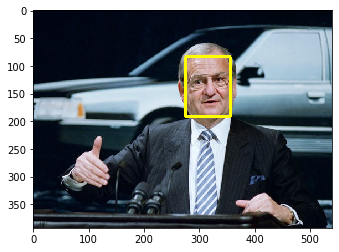

In [6]:
import matplotlib.pyplot as plt
x,y,x1,y1=int(output[0][0]),int(output[0][1]),int(output[0][2]),int(output[0][3])
image = cv2.imread('iacocca_2.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image = cv2.rectangle(image, (x,y), (x1,y1), (255, 255, 0), 3)
plt.imshow(image)

In [10]:
import numpy as np
import cv2

cap = cv2.VideoCapture(0)
 
while(True):
    ret, frame = cap.read()
    gray = cv2.cvtColor(frame,1)
    output = detectFace(gray, 0.7)
    print(output)
    if output == []:
        print("No face found")
    elif isinstance(output[0], list) :
        x,y,x1,y1=int(output[0][0]),int(output[0][1]),int(output[0][2]),int(output[0][3])
        gray = cv2.rectangle(gray, (x,y), (x1,y1), (255, 255, 0), 3)
    cv2.imshow('frame',gray)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

[[270.0, 218.0, 361.0, 331.0, 0.9977192282676697, 296.30467799305916, 259.5123076438904, 338.02610635757446, 260.2886915206909, 312.27808809280396, 286.00602555274963, 298.0895638167858, 308.0054978132248, 331.5264108181, 309.6235400438309]]
[[260.0, 221.0, 361.0, 340.0, 0.9986966252326965, 288.54090654850006, 264.6498912870884, 334.1165758371353, 263.2034206688404, 308.6523193717003, 293.23080587387085, 293.3426775932312, 313.58795034885406, 331.62150382995605, 313.2982372045517]]
[[255.0, 222.0, 359.0, 342.0, 0.9995675683021545, 286.85416889190674, 265.6848157644272, 333.24387383461, 264.22772550582886, 309.2913759946823, 294.6637873649597, 292.088258266449, 313.63980293273926, 330.9826452732086, 313.26536989212036]]
[[265.0, 222.0, 364.0, 343.0, 0.9988526105880737, 293.2434959411621, 264.7537577152252, 337.4407367706299, 266.9191975593567, 309.8535797595978, 294.5641279220581, 294.1275863647461, 316.38562297821045, 328.8983635902405, 318.6683955192566]]
[[259.0, 226.0, 361.0, 340.0,

[[278.0, 141.0, 392.0, 278.0, 0.9988545179367065, 307.73283219337463, 194.27492809295654, 359.3319637775421, 194.52777099609375, 327.40977826714516, 220.41519594192505, 306.3693373799324, 246.49593305587769, 356.0929666161537, 246.7198450565338]]
[[272.0, 145.0, 387.0, 275.0, 0.9995259046554565, 303.45659950375557, 196.92830955982208, 356.6659467816353, 195.9154806137085, 325.1558300256729, 221.8363699913025, 305.0222800076008, 247.5326538681984, 352.2149067521095, 246.96061915159225]]
[[271.0, 147.0, 381.0, 274.0, 0.9999868869781494, 302.13503193855286, 195.73908179998398, 353.18752574920654, 196.28865525126457, 323.98303031921387, 222.06254929304123, 301.0854172706604, 246.68803691864014, 348.87265181541443, 247.64948219060898]]
[[271.0, 148.0, 382.0, 279.0, 0.9999098777770996, 299.00579226017, 196.3768824338913, 350.44335532188416, 196.7063628435135, 318.1588935852051, 222.21505212783813, 298.6743448972702, 247.25310850143433, 346.0777733325958, 248.79165148735046]]
[[269.0, 144.0, 

[[260.0, 161.0, 362.0, 278.0, 0.9999297857284546, 286.58925583958626, 205.74383187294006, 335.3008109331131, 204.14362281560898, 307.42006385326385, 227.4815371632576, 290.0898232758045, 253.52264946699142, 331.37508004903793, 253.15502333641052]]
[[259.0, 161.0, 361.0, 279.0, 0.9999022483825684, 286.423276245594, 206.20988368988037, 335.54150664806366, 204.69877606630325, 307.5385398864746, 227.63279104232788, 289.77182096242905, 253.5088541507721, 331.6477105617523, 253.22744631767273]]
[[259.0, 161.0, 362.0, 279.0, 0.9999455213546753, 285.3183565437794, 206.1447856426239, 334.2003380060196, 203.55672985315323, 305.5590571165085, 227.543252825737, 288.745218873024, 253.47848099470139, 330.79094499349594, 252.71900928020477]]
[[258.0, 159.0, 358.0, 279.0, 0.999804675579071, 284.60439360141754, 204.3611363172531, 333.1173338294029, 203.33616843819618, 304.538139462471, 228.83032321929932, 286.56883376836777, 253.2780717611313, 329.3417328596115, 253.29953467845917]]
[[256.0, 160.0, 359

[[255.0, 158.0, 361.0, 284.0, 0.999531626701355, 283.8400423526764, 205.46543595194817, 333.3865200281143, 202.806032538414, 304.19871455430984, 228.70451098680496, 287.8381026983261, 259.07746744155884, 330.17448246479034, 258.3087683916092]]
[[254.0, 157.0, 360.0, 283.0, 0.999843955039978, 282.17206804454327, 203.76705050468445, 332.82263642549515, 202.72546604275703, 304.72634187340736, 229.49692010879517, 287.49484142661095, 256.93623930215836, 329.38750272989273, 256.42670452594757]]
[[253.0, 158.0, 359.0, 283.0, 0.999806821346283, 282.40187868475914, 203.9803690612316, 332.3085118532181, 202.16532516479492, 305.4390911757946, 229.66110879182816, 288.9916849732399, 258.23061537742615, 329.90389770269394, 256.74739027023315]]
[[246.0, 154.0, 363.0, 294.0, 0.9994807839393616, 280.40769481658936, 202.41241681575775, 333.10010719299316, 200.13723331689835, 302.4054865837097, 228.63872969150543, 286.01077660918236, 262.5837005376816, 328.24607759714127, 261.55280661582947]]
[[245.0, 15

[[261.0, 155.0, 367.0, 282.0, 0.9995447993278503, 291.18487125635147, 203.89305675029755, 340.82996624708176, 202.17813643813133, 313.6337086558342, 227.37308192253113, 295.9296780824661, 255.7312352657318, 336.1741329431534, 255.16965276002884]]
[[259.0, 156.0, 365.0, 283.0, 0.9997081160545349, 289.3275230526924, 204.3853235244751, 339.750150680542, 202.34111815690994, 312.14581364393234, 227.39233672618866, 294.7145491242409, 256.9946950674057, 335.61918818950653, 256.19604647159576]]
[[259.0, 157.0, 365.0, 281.0, 0.999184787273407, 289.4496161341667, 204.61687576770782, 339.2631025314331, 202.08957621455193, 310.53133964538574, 226.77528470754623, 294.08322930336, 256.6049278974533, 335.3264286518097, 255.5691835284233]]
[[260.0, 156.0, 365.0, 281.0, 0.9997813105583191, 290.01958870887756, 204.16402399539948, 339.42128896713257, 201.6530579328537, 311.9535964727402, 226.65697622299194, 295.0251507759094, 256.1308183670044, 335.65371012687683, 255.41365146636963]]
[[262.0, 156.0, 368

# **Code to convert model to tflite**

In [7]:
# Code to load the saved .h5 model

import tensorflow as tf
from tensorflow import keras
new_model = tf.keras.models.load_model('my_onet.h5')


In [8]:
#converting the above loaded model into tflite

converter = tf.lite.TFLiteConverter.from_keras_model(new_model)
tflite_model = converter.convert()

In [9]:
# Save the TF Lite model.
with tf.io.gfile.GFile('onet.tflite', 'wb') as f:
  f.write(tflite_model)

# **Checking the tflite model**

In [11]:
# Checking the input and output shape of the tflite converted model

tflite_interpreter = tf.lite.Interpreter(model_path='onet.tflite')

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])
print("\n== Output details ==")
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

== Input details ==
shape: [ 1 48 48  3]
type: <class 'numpy.float32'>

== Output details ==
shape: [1 2]
type: <class 'numpy.float32'>


In [44]:

import numpy as np
import tensorflow as tf

# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="onet.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data.
input_shape = input_details[0]['shape']
print(input_shape)
image = cv2.imread('iacocca_2.jpg')
image = cv2.resize(img,(48,48))
print(image.shape)
image = np.expand_dims(image,0)
input_data = np.array(image,dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)



[ 1 48 48  3]
(48, 48, 3)
[[1. 0.]]
